# Joint-Dispatch of Energy and Reserve
The joint-dispatch of energy and reserve problem is solved for the real-time electricity market, where the generation outputs of units and the assigned ramp-up and ramp-down reserves are determined jointly to minimize the operating cost.

## Imports

In [2]:
from rsome import ro
from rsome import grb_solver as grb
import rsome as rso

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## System data and notations

- Constants
    - $B$: total number of buses of the power grid (`NB`).
    - $G$: total number of generators in the power grid (`NG`).
- Sets and indices
    - $\mathcal{L}\subseteq [B] \times [B]$: set of transmission lines, where each element $(k, l)\in \mathcal{L}$ indicating that the transmission line connects bus $k$ and bus $l$ (`Lidx`).
    - $\mathcal{B}_i$: set of buses connected to bus $i$ (function `Bset`).
    - $\mathcal{G}_i$: set of generators connected to bus $i$ (function `Gset`).
- Model parameters
    - $\pmb{c}$: generator cost coefficients (`c`).
    - $\underline{\pmb{c}}$, $\bar{\pmb{c}}$: ramp-down and ramp-up reserve costs (`cdown` and `cup`).
    - $\underline{\pmb{g}}$, $\bar{\pmb{g}}$: minimum and maximum real power outputs of generators (`gmin` and `gmax`).
    - $\underline{\pmb{h}}$, $\bar{\pmb{h}}$: minimum and maximum reactive power outputs of generators (`hmin` and `hmax`).
    - $\pmb{A}$, $\pmb{H}$: real and imaginary components of the nodal admittance matrix (`A` and `H`).
    - $\underline{\pmb{v}}$, $\bar{\pmb{v}}$: minimum and maximum squared voltage magnitudes of buses.
    - $\hat{\pmb{z}}$, $\hat{\pmb{w}}$: nominal real and reactive load at each bus (`zhat`, `what`)
    - $\underline{\gamma}$, $\bar{\gamma}$: lower and upper bounds of the tangent of voltage angle differences (`gamma_min` and `gamma_max`).
    - $C_{kl}$: thermal capacity for each $(k, l)$ transmission line (`C`).
    - $\rho$: deterministic reserve requirement (`rho`).

These parameters are defined in the following code segment.

In [4]:
baseMVA = 100

bus = pd.read_excel('ieee_case39.xlsx', sheet_name='bus')
gen = pd.read_excel('ieee_case39.xlsx', sheet_name='gen')
branch = pd.read_excel('ieee_case39.xlsx', sheet_name='branch')

# Sets
Bidx = bus.index
Gidx = gen.index
Lidx = branch[['fbus', 'tbus']]

# Parameters
A = pd.read_excel('ieee_case39.xlsx', sheet_name='G').values
H = pd.read_excel('ieee_case39.xlsx', sheet_name='B').values
vmin, vmax = bus['Vmin'].values**2, bus['Vmax'].values**2
zhat = bus['Pd'].values / baseMVA
what = bus['Qd'].values / baseMVA

c = gen['Cost'].values
cup = c * 0.25
cdown = c * 0.25

gmin, gmax = gen['Pmin'].values / baseMVA, gen['Pmax'].values / baseMVA
hmin, hmax = gen['Qmin'].values / baseMVA, gen['Qmax'].values / baseMVA
θmin = branch['angmin'] * np.pi / 180
θmax = branch['angmax'] * np.pi / 180
gamma_min = np.tan(θmin.values)[0]
gamma_max = np.tan(θmax.values)[0]
C = branch['rateA'] / baseMVA

# Function
Gset = lambda j: gen.index[gen['bus'] == j].tolist()
Bset = lambda j: list(branch.loc[branch['fbus'] == j, 'tbus']) + list(branch.loc[branch['tbus'] == j, 'fbus'])

## Decision Model for Energy and Reserve Dispatch

### AC power flow and reserve constraints

Consider the here-and-now decision variables:

- $\pmb{p}$, $\pmb{q}$: real and reactive power outputs of generators (`p` and `q`).
- $\underline{\pmb{r}}$, $\bar{\pmb{r}}$: ramp-down and ramp-up reserve supplied by generators (`rd` and `ru`).

The decision variables are subject the following operating constraints defined by the set $\mathcal{X}$:
\begin{align}
\mathcal{X} = \left\{
(\pmb{p}, \pmb{q}, \underline{\pmb{r}}, \bar{\pmb{r}}) \in \mathbb{R}^G \times \mathbb{R}^G \times \mathbb{R}_+^G \times \mathbb{R}_+^G ~\left|~
\begin{array}{l}
(\pmb{p}, \pmb{q}, \hat{\pmb{z}}) \in \mathcal{N} \\
\underline{\pmb{g}} + \underline{\pmb{r}} \leq \pmb{p} \leq \bar{\pmb{g}} - \bar{\pmb{r}} \\
\underline{\pmb{h}} \leq \pmb{q} \leq \bar{\pmb{h}}
\end{array}
\right.
\right\},
\end{align}

where the set $\mathcal{Q}$ defines constraints for the AC power flow under the real power load $\pmb{z}$:

\begin{align}
\mathcal{Q} = \left\{
(\pmb{p}, \pmb{q}, \pmb{z}) \in \mathbb{R}^G \times \mathbb{R}^G \times \mathbb{R}^B ~ \left| ~
\begin{array}{ll}
\exists \pmb{y} \in \mathbb{R}_+^B, ~~~\underline{y}_{kl}, \bar{y}_{kl} \in \mathbb{R} ~ \forall (k, l) \in \mathcal{L}: \\
\sum\limits_{l\in\mathcal{G}_j}p_l - z_j = A_{jj}y_j + \sum\limits_{l \in \mathcal{B}_j}\left(A_{jl}\bar{y}_{jl} - H_{jl}\underline{y}_{jl}\right) &\forall j \in [B] \\
\sum\limits_{l\in\mathcal{G}_j}q_l - \hat{w}_j = -H_{jj}y_j + \sum\limits_{l \in \mathcal{B}_j}\left(-H_{jl}\bar{y}_{jl} - A_{jl}\underline{y}_{jl}\right) &\forall j \in [B] \\
\underline{\pmb{v}} \leq \pmb{y} \leq \bar{\pmb{v}} \\
\underline{\gamma}\cdot \bar{\pmb{y}} \leq \underline{\pmb{y}} \leq \bar{\gamma} \cdot \bar{\pmb{y}} \\
\left(A_{kl}y_k + A_{kl}\bar{y}_{(k, l)} - H_{kl}\underline{y}_{(k, l)}\right)^2 + \left(H_{kl}y_k - H_{kl}\bar{y}_{(k, l)} - A_{kl}\underline{y}_{(k, l)}\right)^2 \leq C_{kl} &\forall (k, l) \in \mathcal{L} \\
\bar{y}_{(k, l)} = \bar{y}_{(l, k)}, ~\underline{y}_{(k, l)}=\underline{y}_{(l, k)}, ~ \bar{y}_{(k, l)}^2 + \underline{y}_{(k, l)} \leq y_ky_l & \forall (k, l) \in \mathcal{L}
\end{array}
\right.
\right\}.
\end{align}

Besides, we consider the attribute function $f(\pmb{p}, \underline{\pmb{r}}, \bar{\pmb{r}})$ to ensure that, for a given here-and-now decision $(\pmb{p}, \underline{\pmb{r}}, \bar{\pmb{r}})$, all operating constraints are satisfied under a realized real power load scenario $\pmb{z}$:

\begin{align}
f(\pmb{p}, \underline{\pmb{r}}, \bar{\pmb{r}}) = \left\{
\begin{array}{l}
\min&0 \\
\text{s.t.}&\pmb{p} - \underline{\pmb{r}} \leq \bar{\pmb{p}} \leq \pmb{p} + \bar{\pmb{r}} \\
&\underline{\pmb{h}} \leq \bar{\pmb{q}} \leq \bar{\pmb{h}} \\
&(\bar{\pmb{p}}, \bar{\pmb{q}}, \pmb{z}) \in \mathcal{Q} \\
&\bar{\pmb{p}}\in\mathbb{R}^G,~\bar{\pmb{q}}\in\mathbb{R}^G.
\end{array}
\right.
\end{align}

Note that the value of function $f(\pmb{p}, \underline{\pmb{r}}, \bar{\pmb{r}})$ is constantly 0 if all operating constraints under the real power load $\pmb{z}$ are satisfied and goes to infinity otherwise. We therefore focus on the constraints of $f(\pmb{p}, \underline{\pmb{r}}, \bar{\pmb{r}})$ in defining the class of the dispatch model below.

In [6]:
class PFModel(ro.Model):

    def st_Qset(self, p, q, z):
        """
        Enforce AC power constraints defined in the set Q.
        """

        NB = len(Bidx)
        NL = len(Lidx)
        Iby = np.zeros((NB, NB, NL))
        Iby[Lidx['fbus'], Lidx['tbus'], Lidx.index] = 1

        y = self.dvar(NB)
        yup_mat = Iby @ self.dvar(NL)
        ydown_mat = Iby @ self.dvar(NL)
        yup = yup_mat + yup_mat.T
        ydown = ydown_mat - ydown_mat.T

        w = what
        constrs = []
        for j in Bidx:
            k, l = Gset(j), Bset(j)
            constrs.append(sum(p[k]) - z[j] == A[j, j]*y[j] + sum(A[j, l]*yup[j, l] - H[j, l]*ydown[j, l]))
            constrs.append(sum(q[k]) - w[j] == -H[j, j]*y[j] + sum(-H[j, l]*yup[j, l] - A[j, l]*ydown[j, l]))

        constrs.extend([vmin <= y, y <= vmax])
        for i, k, l in zip(Lidx.index, Lidx['fbus'], Lidx['tbus']):
            constrs.extend([gamma_min*yup[k, l] <= ydown[k, l], ydown[k, l] <= gamma_max*yup[k, l]])
            constrs.append(rso.sumsqr(-A[k, l]*y[k] + A[k, l]*yup[k, l] - H[k, l]*ydown[k, l],
                                      H[k, l]*y[k] - H[k, l]*yup[k, l] - A[k, l]*ydown[k, l]) <= C[i]**2)
            constrs.append(rso.rsocone([yup[k, l], ydown[k, l]], y[k], y[l]))

        self.st(*constrs)

    def st_Xset(self, p, q, rd, ru):
        """
        Enforce nomial operating constraints defined in the set X.
        """

        self.st_Qset(p, q, zhat)

        constrs = [rd >= 0, ru >= 0,
                   gmin + rd <= p, p <= gmax - ru,
                   hmin <= q, q <= hmax]

        self.st(*constrs)

    def st_fconst(self, p, rd, ru, z):
        """
        Enforce operating constraints under the real power load z of the attribute
        function f, given the here-and-now decision (p, rd, ru).
        """

        NG = len(Gidx)

        pbar = self.dvar(NG, name='pbar')
        qbar = self.dvar(NG, name='qbar')

        self.st_Qset(pbar, qbar, z)

        constrs = [p - rd <= pbar, pbar <= p + ru,
                   hmin <= qbar, qbar <= hmax]

        self.st(*constrs)

### Deterministic model

Conventionally, the reserve margin is specified by a deterministic requirement, denoted by $\rho$, so such as deterministic model can be defined as below.

\begin{align}
\min~&\pmb{c}^{\top}\pmb{p} + \bar{\pmb{c}}^{\top}\bar{\pmb{r}} + \underline{\pmb{c}}^{\top}\underline{\pmb{r}}\\
\text{s.t. }&\pmb{1}^{\top}\underline{\pmb{r}} \geq \rho,~\pmb{1}^{\top}\bar{\pmb{r}} \geq \rho \\
&(\pmb{p}, \pmb{q}, \underline{\pmb{r}}, \bar{\pmb{r}}) \in \mathcal{X}
\end{align}

In [8]:
def det_model(rho, solver):

    model = PFModel()

    NG = len(Gidx)
    p = model.dvar(NG)
    ru = model.dvar(NG)
    rd = model.dvar(NG)
    q = model.dvar(NG)

    model.min((c@p + cup@ru + cdown@rd) * baseMVA)
    model.st(ru >= 0, rd >= 0, ru.sum() >= rho, rd.sum() >= rho)
    model.st_Xset(p, q, rd, ru)

    model.solve(solver)

    return model.get(), model.solution.time, {'p': p.get(), 'q': q.get(),
                                              'ru': ru.get(), 'rd': rd.get()}

### Stochastic optimization model

Instead of a deterministic reserve requirement, we can also use a scenario-representation of uncertain power demand to formulate the following stochastic optimization model:

\begin{align}
\min~&\pmb{c}^{\top}\pmb{p} + \bar{\pmb{c}}^{\top}\bar{\pmb{r}} + \underline{\pmb{c}}^{\top}\underline{\pmb{r}}\\
\text{s.t. }&f(\pmb{p}, \underline{\pmb{r}}, \bar{\pmb{r}}, \pmb{z}_s) \leq 0 &s\in [S] \\
&(\pmb{p}, \pmb{q}, \underline{\pmb{r}}, \bar{\pmb{r}}) \in \mathcal{X}
\end{align}

where $\pmb{z}_s$, $s\in[S]$, are samples drawn from the distribution of the uncertain real power load.

In [10]:
def sto_model(zs, solver):

    model = PFModel()

    NG = len(Gidx)
    NB = len(Bidx)

    p = model.dvar(NG)
    ru = model.dvar(NG)
    rd = model.dvar(NG)
    q = model.dvar(NG)

    model.min((c@p + cup@ru + cdown@rd) * baseMVA)
    model.st_Xset(p, q, rd, ru)
    for s in range(len(zs)):
        model.st_fconst(p, rd, ru, zs[s])

    model.solve(grb)

    return model.get(), model.solution.time, {'p': p.get(), 'q': q.get(),
                                              'ru': ru.get(), 'rd': rd.get()}

### Streamlined robustness model

The following streamlined robustness model maximizes the uncertainty set under which there is no violation of operating constraint within the given cost budget $\eta$:

\begin{align}
\max~&\theta\\
\text{s.t. }&\pmb{c}^{\top}\pmb{p} + \bar{\pmb{c}}^{\top}\bar{\pmb{r}} + \underline{\pmb{c}}^{\top}\underline{\pmb{r}}\leq \eta \\
&f(\pmb{p}, \underline{\pmb{r}}, \bar{\pmb{r}}, \hat{\pmb{z}} + \theta\pmb{D}\pmb{e}_i) \leq 0 &i\in [B] \\
&f(\pmb{p}, \underline{\pmb{r}}, \bar{\pmb{r}}, \hat{\pmb{z}} - \theta\pmb{D}\pmb{e}_i) \leq 0 &i\in [B] \\
&(\pmb{p}, \pmb{q}, \underline{\pmb{r}}, \bar{\pmb{r}}) \in \mathcal{X}.
\end{align}

In [12]:
def rs_model(eta, D, solver):

    model = PFModel()

    NG = len(Gidx)
    NB = len(Bidx)
    idx = np.where(zhat)[0]
    ND = len(idx)

    p = model.dvar(NG)
    ru = model.dvar(NG)
    rd = model.dvar(NG)
    q = model.dvar(NG)
    theta = model.dvar()

    model.max(theta)
    model.st((c@p + cup@ru + cdown@rd) * baseMVA <= eta)
    model.st_Xset(p, q, rd, ru)
    for i in range(ND):
        ei = np.zeros(NB)
        ei[idx[i]] = 1
        model.st_fconst(p, rd, ru, zhat + theta*D@ei)
        model.st_fconst(p, rd, ru, zhat - theta*D@ei)

    model.solve(solver)

    return model.get(), model.solution.time, {'p': p.get(), 'q': q.get(),
                                              'ru': ru.get(), 'rd': rd.get()}

## Numerical Studies

### Simulations

Given a dispatch decision $(\pmb{p}, \underline{\pmb{r}}, \bar{\pmb{r}})$, the following model is solved repeatedly for randomly generated load samples $\pmb{z}^s$:

\begin{align}
\min &\pmb{1}^{\top}(\underline{\pmb{d}} + \bar{\pmb{d}}) \\
\text{s.t.}&f(\pmb{p}, \underline{\pmb{r}}+\underline{\pmb{d}}, \bar{\pmb{r}}+\bar{\pmb{d}}, \pmb{z}^s) \leq 0 \\
&\underline{\pmb{d}} \in \mathbb{R}_+^G, ~\bar{\pmb{d}} \in \mathbb{R}_+^G
\end{align}

where the objective value indicates the violation of operating constraints under $\pmb{z}^s$.

In [14]:
def one_sim(p, rd, ru, zs, solver):

    model = PFModel()

    dd = model.dvar(len(Gidx))
    du = model.dvar(len(Gidx))

    model.min((dd + du).sum())
    model.st_fconst(p, rd+dd, ru+du, zs)
    model.st(dd >= 0, du >= 0)

    model.solve(solver, display=False)

    return [model.get()]

In [15]:
from multiprocess import Pool

def erd_sim(p, ru, rd, zs, solver, n_jobs=5):

    with Pool(n_jobs) as pr:
        params = [[p, rd, ru, z, solver] for z in zs]
        results = pr.starmap(one_sim, params)

    return results

### Experiments

In [17]:
from rsome import grb_solver as grb

sigma = 0.15
D = np.diag(sigma * zhat)

NS = 1000
np.random.seed(0)
zsim = zhat * (1 + sigma*np.random.randn(NS, len(zhat)))

det_violation = np.zeros(11)
det_failure_rates = np.zeros(11)

rs_violation = np.zeros(11)
rs_failure_rates = np.zeros(11)

targets = np.zeros(11)
det_sols = []
det_times = []
rs_sols = []
rs_times = []

for i in range(1, 12):
    rho = (3.4 + 0.6*i)* 0.1 * sigma * zhat.sum()

    target, det_time, det_sol = det_model(rho, grb)
    theta_rs, rs_time, rs_sol = rs_model(target, D, grb)
    det_sols.append(det_sol)
    det_times.append(det_time)
    rs_sols.append(rs_sol)
    rs_times.append(rs_time)
    targets[i-1] = target

    det_results = np.array(erd_sim(det_sol['p'], det_sol['ru'], det_sol['rd'], zsim, grb, n_jobs=10))
    rs_results = np.array(erd_sim(rs_sol['p'], rs_sol['ru'], rs_sol['rd'], zsim, grb, n_jobs=10))

    det_violation[i-1] = det_results[:, 0].mean()
    rs_violation[i-1] = rs_results[:, 0].mean()

    det_failure_rates[i-1] = (det_results[:, 0] > 1e-4).mean()
    rs_failure_rates[i-1] = (rs_results[:, 0] > 1e-4).mean()

    print('\n')

Set parameter Username
Academic license - for non-commercial use only - expires 2026-02-25
Being solved by Gurobi...
Solution status: 2
Running time: 0.0436s
Being solved by Gurobi...
Solution status: 2
Running time: 0.8924s


Being solved by Gurobi...
Solution status: 2
Running time: 0.0391s
Being solved by Gurobi...
Solution status: 2
Running time: 0.7792s


Being solved by Gurobi...
Solution status: 2
Running time: 0.0471s
Being solved by Gurobi...
Solution status: 2
Running time: 0.7753s


Being solved by Gurobi...
Solution status: 2
Running time: 0.0421s
Being solved by Gurobi...
Solution status: 2
Running time: 0.7553s


Being solved by Gurobi...
Solution status: 2
Running time: 0.0447s
Being solved by Gurobi...
Solution status: 2
Running time: 0.8902s


Being solved by Gurobi...
Solution status: 2
Running time: 0.0476s
Being solved by Gurobi...
Solution status: 2
Running time: 0.7034s


Being solved by Gurobi...
Solution status: 2
Running time: 0.0431s
Being solved by Gurobi...


### Visualization of results

In [19]:
repeats = 3
batches = 4
sto_violation = np.zeros((batches, repeats))
sto_failure_rates = np.zeros((batches, repeats))
sto_dispatch_costs = np.zeros((batches, repeats))
sto_sols = []
sto_times = []
for j in range(1, batches+1):
    sols = []
    times = []
    for n in range(repeats):
        zin = zhat * (1 + sigma*np.random.randn(j*20, len(zhat)))
        ecost, sto_time, sto_sol = sto_model(zin, grb)

        sols.append(sto_sol)
        times.append(sto_time)

        sto_results = np.array(erd_sim(sto_sol['p'], sto_sol['ru'], sto_sol['rd'], zsim, grb, n_jobs=10))
        sto_violation[j-1, n] = sto_results[:, 0].mean()
        sto_failure_rates[j-1, n] = (sto_results[:, 0] > 1e-4).mean()
        sto_dispatch_costs[j-1, n] = ecost

        print(' ')

    print('-------------------------------------------------')

    sto_sols.append(sols)
    sto_times.append(times)

Being solved by Gurobi...
Solution status: 2
Running time: 0.2974s
 
Being solved by Gurobi...
Solution status: 2
Running time: 0.2735s
 
Being solved by Gurobi...
Solution status: 2
Running time: 0.2864s
 
-------------------------------------------------
Being solved by Gurobi...
Solution status: 2
Running time: 0.4023s
 
Being solved by Gurobi...
Solution status: 2
Running time: 0.5365s
 
Being solved by Gurobi...
Solution status: 2
Running time: 0.4971s
 
-------------------------------------------------
Being solved by Gurobi...
Solution status: 2
Running time: 0.8786s
 
Being solved by Gurobi...
Solution status: 2
Running time: 0.9574s
 
Being solved by Gurobi...
Solution status: 2
Running time: 0.8465s
 
-------------------------------------------------
Being solved by Gurobi...
Solution status: 13
Running time: 5.3719s
 
Being solved by Gurobi...
Solution status: 13
Running time: 3.1747s
 
Being solved by Gurobi...
Solution status: 13
Running time: 5.0677s
 
-------------------

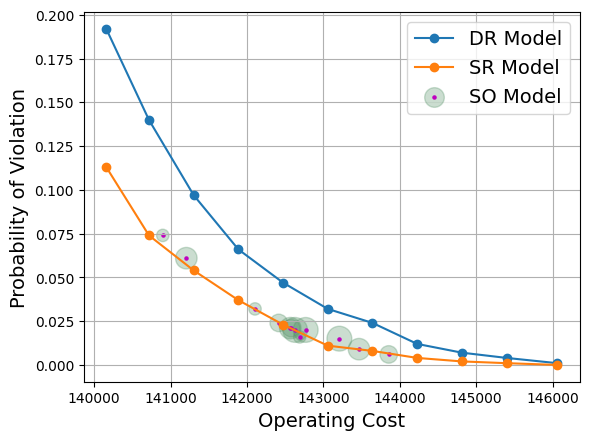

In [158]:
plt.figure(dpi=100)
l1 = plt.plot(targets, det_failure_rates, marker='o')
l2 = plt.plot(targets, rs_failure_rates, marker='o')
s1 = plt.scatter(sto_dispatch_costs.flatten(), sto_failure_rates.flatten(),
                 s=((np.arange(1, batches+1))[:, None] * np.ones(repeats)).flatten()*80,
                 facecolor=(0.33, 0.57, 0.40, 0.3))
s2 = plt.scatter(sto_dispatch_costs.flatten(), sto_failure_rates.flatten(), marker='.', c='m', s=20)

plt.legend(handles=(l1[0], l2[0], (s1, s2)),
           labels=('DR Model', 'SR Model', 'SO Model'),
           fontsize=14)
plt.grid()
plt.xlabel('Operating Cost', fontsize=14)
plt.ylabel('Probability of Violation', fontsize=14)
plt.show()

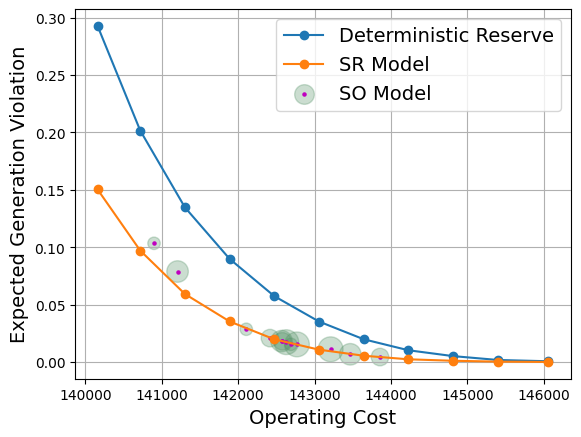

In [160]:
plt.figure(dpi=100)
l1 = plt.plot(targets, det_violation, marker='o')
l2 = plt.plot(targets, rs_violation, marker='o')
idx = np.argsort(sto_dispatch_costs)
s1 = plt.scatter(sto_dispatch_costs.flatten(), sto_violation.flatten(),
                 s=((np.arange(1, batches+1))[:, None] * np.ones(repeats)).flatten()*80,
                 facecolor=(0.33, 0.57, 0.40, 0.3))
s2 = plt.scatter(sto_dispatch_costs.flatten(), sto_violation.flatten(), marker='.', c='m', s=20)

plt.legend(handles=(l1[0], l2[0], (s1, s2)),
           labels=('Deterministic Reserve', 'SR Model', 'SO Model'),
           fontsize=14)
plt.grid()
plt.xlabel('Operating Cost', fontsize=14)
plt.ylabel('Expected Generation Violation', fontsize=14)
plt.show()

In [22]:
timetable = pd.DataFrame([np.array(rs_times).mean()], columns=pd.MultiIndex.from_tuples([('RS Model', '-')]))
timetable[[('SO', 'Sample=20'), ('SO', 'Sample=40'), ('SO', 'Sample=60'), ('SO', 'Sample=80')]] = np.array(sto_times).mean(axis=1)[None, :]
timetable

RS Model        SO                              
         - Sample=20 Sample=40 Sample=60 Sample=80
0  0.74061  0.285765  0.478651  0.894184  4.538084